In [ ]:
!pip install scipy --upgrade

In [1]:
import scipy.io
import numpy as np
from tqdm.auto import tqdm
from google.colab import drive
import matplotlib.pyplot as plt
from itertools import combinations

# pytorch for neural network
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary

from sklearn import svm
from sklearn.metrics import f1_score, accuracy_score, classification_report

torch.manual_seed(0)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [2]:
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Thesis/WorkSpace

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Thesis/WorkSpace


In [3]:
from modules import data_f, network_f, network_architectures

### load the data from mat file

In [4]:
mat = scipy.io.loadmat('datasets/DREAMER.mat', simplify_cells=True)
data = mat['DREAMER']['Data']
score_types = ['ScoreValence', 'ScoreArousal', 'ScoreDominance']

## Using full dataset

### interpolate the signals to be of equal length

In [5]:
#person1 = data[0]

inputs = []
labels = []
for person in tqdm(data):
  scores = np.swapaxes([vals for info, vals in person.items() if 'Score' in info], 0, 1)
  # scores -= 1  # [1,5] -> [0,4]
  scores = np.where(scores>=2.5, 1, 0).astype(float)  # [1,5] -> 0/1 

  person_signals = []
  for vid in tqdm(range(18), leave=False):
    signal_vals = []
    for signal_type in ['EEG', 'ECG']:
      for signal_mode in ['baseline', 'stimuli']:
        signal = person[signal_type][signal_mode][vid]
        for channel in np.swapaxes(signal,0,1):
          ch_interp = np.interp(np.linspace(0,len(channel)-1,32768), range(len(channel)), channel)
          signal_vals.append(ch_interp)
    person_signals.append(signal_vals)

  inputs.extend(person_signals)
  labels.extend(scores)  


inputs = np.array(inputs)
labels = np.array(labels)
print(inputs.shape)
print(labels.shape, np.unique(labels))

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

(414, 32, 32768)
(414, 3) [0. 1.]


### normalize the signals to be in range(-1,1)

In [6]:
data_f.normalize(inputs)

### create dataloader

In [7]:
dataloaders = {'train' : data_f.createLoader(inputs, labels, batch_size=32)}

### define the network

view network summary

In [8]:
model = network_architectures.Conv_Classifier(num_classes=3, inp_channels=32)
model = model.to(device)

summary(model, (32,32768))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 64, 8190]          24,640
              ReLU-2             [-1, 64, 8190]               0
         MaxPool1d-3             [-1, 64, 2048]               0
            Conv1d-4             [-1, 192, 512]          49,344
              ReLU-5             [-1, 192, 512]               0
         MaxPool1d-6             [-1, 192, 128]               0
            Conv1d-7             [-1, 384, 128]         221,568
              ReLU-8             [-1, 384, 128]               0
            Conv1d-9             [-1, 256, 128]         295,168
             ReLU-10             [-1, 256, 128]               0
           Conv1d-11             [-1, 256, 128]         196,864
             ReLU-12             [-1, 256, 128]               0
        MaxPool1d-13              [-1, 256, 32]               0
AdaptiveAvgPool1d-14               [-1,

set criterion and optimizer

In [9]:
# Define a Loss function and optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train the network

training network


  0%|          | 0/100 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 10  | train loss: 0.108, val loss: nan  | avg train loss: 0.223, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 20  | train loss: 0.108, val loss: nan  | avg train loss: 0.095, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 30  | train loss: 0.024, val loss: nan  | avg train loss: 0.079, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 40  | train loss: 0.030, val loss: nan  | avg train loss: 0.070, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 50  | train loss: 0.011, val loss: nan  | avg train loss: 0.032, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 60  | train loss: 0.021, val loss: nan  | avg train loss: 0.051, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 70  | train loss: 0.023, val loss: nan  | avg train loss: 0.039, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 80  | train loss: 0.040, val loss: nan  | avg train loss: 0.019, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 90  | train loss: 0.038, val loss: nan  | avg train loss: 0.057, avg val loss: nan


train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

train:   0%|          | 0/13 [00:00<?, ?it/s]

epoch: 100  | train loss: 0.001, val loss: nan  | avg train loss: 0.003, avg val loss: nan
Finished Training


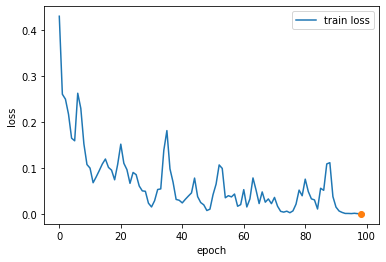

In [46]:
model.apply(network_f.weight_reset)
optimizer = optim.Adam(model.parameters(), lr=0.001)

best_params = network_f.trainNet(model, criterion, optimizer, dataloaders, epochs=100)

In [47]:
model.load_state_dict(best_params)

<All keys matched successfully>

### evaluate

In [51]:
print("evaluation results on train data")
loader = data_f.createLoader(inputs, labels, batch_size=32)
lbl_true, lbl_pred = network_f.get_predn(model, loader, predict_fn='threshold')
lbl_true, lbl_pred = [list(lbl) for lbl in lbl_true], [list(lbl) for lbl in lbl_pred]
print(classification_report(lbl_true, lbl_pred, target_names=score_types))

evaluation results on train data
                precision    recall  f1-score   support

  ScoreValence       1.00      1.00      1.00       253
  ScoreArousal       1.00      1.00      1.00       300
ScoreDominance       1.00      1.00      1.00       319

     micro avg       1.00      1.00      1.00       872
     macro avg       1.00      1.00      1.00       872
  weighted avg       1.00      1.00      1.00       872
   samples avg       0.95      0.95      0.95       872



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Leave one out cross validation on groups

as mentioned in the dataset: https://ieeexplore.ieee.org/document/7887697

In [5]:
results = dict.fromkeys(score_types)
for score_type in results:
  results[score_type] = {'Accuracy':[], 'F1 Score':[]}

def print_scores(results):
  for metric in ['Accuracy', 'F1 Score']:
    print(metric)
    for score_type in score_types:
      print(f'{score_type} : {np.mean(results[score_type][metric]):.4f}')
    print()

### using conv neural net

In [13]:
for person in tqdm(data):

  # get the input signals and scores
  person_signals = []
  for vid in tqdm(range(18), leave=False):
    signal_vals = []
    for signal_type in ['EEG', 'ECG']:
      for signal_mode in ['baseline', 'stimuli']:
        signal = person[signal_type][signal_mode][vid]
        for channel in np.swapaxes(signal,0,1):
          ch_interp = np.interp(np.linspace(0,len(channel)-1,32768), range(len(channel)), channel)  # interpolate
          signal_vals.append(ch_interp)
    person_signals.append(signal_vals)

  person_signals = np.array(person_signals) # normalize
  data_f.normalize(person_signals)

  scores = np.swapaxes([vals for info, vals in person.items() if 'Score' in info], 0, 1)
  scores = np.where(scores>=2.5, 1, 0).astype(float)

  # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
  groups = np.random.choice(range(18), (8,2), replace=False)
  single_groups = [i for i in range(18) if i not in groups]
  groups = [list(group) for group in groups] + single_groups

  for test_group in tqdm(groups):
    train_groups = [group for group in groups if group!=test_group]
    train_groups = np.hstack(train_groups)
    if type(test_group) == int: test_group = [test_group]
    
    train_inputs, train_labels = person_signals[train_groups], scores[train_groups]
    test_inputs, test_labels = person_signals[test_group], scores[test_group]


    dataloaders = data_f.create_trainValLoaders(train_inputs, train_labels, test_size=1, batch_size=2)
    dataloaders['test'] = data_f.createLoader(test_inputs, test_labels, batch_size=2)

    model = network_architectures.Conv_Classifier(num_classes=3, inp_channels=32)
    model = model.to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    best_params = network_f.trainNet(model, criterion, optimizer, {'train':dataloaders['train']}, epochs=10, verbose=0)
    model.load_state_dict(best_params)

    lbl_true, lbl_pred = network_f.get_predn(model, dataloaders['test'], predict_fn='threshold')
    lbl_true, lbl_pred = list(zip(*lbl_true)), list(zip(*lbl_pred))

    for score_indx, score_type in enumerate(score_types):
      results[score_type]['F1 Score'].append(f1_score(lbl_true[score_indx], lbl_pred[score_indx]))
      results[score_type]['Accuracy'].append(accuracy_score(lbl_true[score_indx], lbl_pred[score_indx]))
  
  print_scores(results)
  # break

view final scores

In [ ]:
print_scores(results)

Accuracy
ScoreValence : 0.5000
ScoreArousal : 0.6196
ScoreDominance : 0.6370

F1 Score
ScoreValence : 0.3580
ScoreArousal : 0.6261
ScoreDominance : 0.6406



### using SVM

In [ ]:
for _ in tqdm(range(10)):
  for person in tqdm(data, leave=False):

    # get the input signals and scores
    person_signals = []
    for vid in tqdm(range(18), leave=False):
      signal_vals = []
      for signal_type in ['EEG', 'ECG']:
        for signal_mode in ['baseline', 'stimuli']:
          signal = person[signal_type][signal_mode][vid]
          for channel in np.swapaxes(signal,0,1):
            ch_interp = np.interp(np.linspace(0,len(channel)-1,32768), range(len(channel)), channel)  # interpolate
            signal_vals.append(ch_interp)
      person_signals.append(signal_vals)

    person_signals = np.array(person_signals) # normalize
    data_f.normalize(person_signals)

    scores = np.swapaxes([vals for info, vals in person.items() if 'Score' in info], 0, 1)
    scores = np.where(scores>=2.5, 1, 0).astype(float)

    # divide into groups as mentioned in the paper: https://ieeexplore.ieee.org/document/7887697
    groups = np.random.choice(range(18), (8,2), replace=False)
    single_groups = [i for i in range(18) if i not in groups]
    groups = [list(group) for group in groups] + single_groups

    for test_group in tqdm(groups, leave=False):
      train_groups = [group for group in groups if group!=test_group]
      train_groups = np.hstack(train_groups)
      if type(test_group) == int: test_group = [test_group]
      
      train_inputs, train_labels = person_signals[train_groups], scores[train_groups]
      test_inputs, test_labels = person_signals[test_group], scores[test_group]

      # train an SVM for each score type
      for score_indx, score_type in enumerate(score_types):
        clf = svm.SVC()
        # clf = svm.LinearSVC()
        n_classes = np.unique(train_labels[:,score_indx])
        if len(n_classes) == 2:
          clf.fit(train_inputs.reshape(train_inputs.shape[0],-1), train_labels[:,score_indx])
          lbl_pred = clf.predict(test_inputs.reshape(test_inputs.shape[0],-1))
        elif len(n_classes) == 1:
          pred_class = n_classes[0]
          lbl_pred = np.full_like(test_labels[:,score_indx], pred_class)

        results[score_type]['F1 Score'].append(f1_score(test_labels[:,score_indx], lbl_pred, zero_division=0))
        results[score_type]['Accuracy'].append(accuracy_score(test_labels[:,score_indx], lbl_pred))  

  print_scores(results)

In [12]:
print_scores(results)

Accuracy
ScoreValence : 0.5812
ScoreArousal : 0.6838
ScoreDominance : 0.7577

F1 Score
ScoreValence : 0.5145
ScoreArousal : 0.7259
ScoreDominance : 0.7689

